# Install Dependencies and Libraries

In [23]:
!pip install scikit-learn
!pip install sklearn_evaluation
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install numpy

  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached mistune-3.1.4-py3-none-any.whl.metadata (1.8 kB)
  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached urllib3-2.5.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached fastjsonschema-2.21.2-py3-none-any.whl.metadata (2.3 kB)
  Using cached jsonschema-4.25.1-py3-none-any.whl.metadata (7.6 kB)
  Using cached jsonschema_specifications-2025.9.1-py3-none-any.whl.metadata (2.9 kB)
Using cached requests-2.32.5-py3-none-any.whl (64 kB)
Using cached urllib3-2.5.0-py3-none-any.whl (129 kB)
Using cached typing_extensions-4.15.0-py3-none-any.whl (44 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.9 MB/s  0:00:00
Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)
Using cached mistune-3.1.4-py3-none-any.whl (53 kB)
Using cached nbformat-5.10.4-

# Split dataset into training and test using Train_Test_Split method

In [138]:
# Preprocessing
import pandas as pd #import pandas library for reading CSV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset and drop duplicates if any
data = pd.read_csv('steel.csv')
data = data.drop_duplicates().reset_index(drop=True)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('tensile_strength', axis=1),  # Drop the target column from features
    data['tensile_strength'], # Target variable
    test_size=0.3, # 30% test size
    random_state=42) # Random state for reproducibility 



# Gaussian Process Model Fitting Without any Preprocessing or Cross Fold Validation

In [152]:
# ==== GAUSSIAN PROCESS REGRESSION MODEL TRAINING WITH DEFAULT HYPERPARAMETERS (without cross fold validation)====

from sklearn.gaussian_process import GaussianProcessRegressor

rgr = GaussianProcessRegressor()
rgr.fit(X_train, y_train)
y_train_pred = rgr.predict(X_train)

print("\n=== Training Data Performance ===")
print(f"Train MSE: {mean_squared_error(y_train, y_train_pred):.4f}") # Mean Squared Error for training data
print(f"Train R²: {r2_score(y_train, y_train_pred):.4f}") # Metric for how well model performs on training data it already saw

y_test_pred = rgr.predict(X_test)
print("\n=== Test Data Performance ===")
print(f"Test MSE: {mean_squared_error(y_test, y_test_pred):.4f}") # Mean Squared Error for test data
print(f"Test R²: {r2_score(y_test, y_test_pred):.4f}") # Metric for how well model performs on test data it hasn't seen before


=== Training Data Performance ===
Train MSE: 0.0000
Train R²: 1.0000

=== Test Data Performance ===
Test MSE: 14903.7841
Test R²: -0.7933


# 10 Fold Cross Validation with no pre processing

In [153]:
# ==== GAUSSIAN PROCESS REGRESSION MODEL TRAINING WITH DEFAULT HYPERPARAMETERS====

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import cross_validate

gpr_default = GaussianProcessRegressor()

cv_results_default = cross_validate(
    gpr_default,
    X_train,  
    y_train, 
    cv=10,
    scoring={
        'mse': 'neg_mean_squared_error',  # Domain-specific
        'r2': 'r2'                         # Domain-independent
    },
    return_train_score=True,
    n_jobs=-1
)

print("\nDefault Results (averaged over 10 folds):")
print(f"  Training MSE:   {-cv_results_default['train_mse'].mean():.4f} "
      f"(± {cv_results_default['train_mse'].std():.4f})")
print(f"  Test MSE:       {-cv_results_default['test_mse'].mean():.4f} "
      f"(± {cv_results_default['test_mse'].std():.4f})")
print(f"  Training R²:    {cv_results_default['train_r2'].mean():.4f} "
      f"(± {cv_results_default['train_r2'].std():.4f})")
print(f"  Test R²:        {cv_results_default['test_r2'].mean():.4f} "
      f"(± {cv_results_default['test_r2'].std():.4f})")


Default Results (averaged over 10 folds):
  Training MSE:   0.0000 (± 0.0000)
  Test MSE:       16063.4494 (± 5603.4564)
  Training R²:    1.0000 (± 0.0000)
  Test R²:        -1.0310 (± 0.5722)


# Scale the Features in the dataset

In [168]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

print("\nOriginal feature ranges:")
print(X_train.describe().loc[['min', 'max']])
print("\nScaled feature ranges:")
print(X_train_scaled.describe().loc[['min', 'max']])

X_test_scaled  = scaler.transform(X_test)

gpr = GaussianProcessRegressor()
gpr.fit(X_train_scaled, y_train)



Original feature ranges:
     normalising_temperature  tempering_temperature  percent_silicon  \
min                    178.5                  225.0           0.0000   
max                    945.0                  950.0           0.3594   

     percent_chromium  percent_copper  percent_nickel  percent_sulphur  \
min          0.745783           0.594           0.801            0.000   
max          1.794173           0.945           1.125            0.322   

     percent_carbon  percent_manganese  
min           1.378               0.00  
max           2.370               1.93  

Scaled feature ranges:
     normalising_temperature  tempering_temperature  percent_silicon  \
min                -1.921235              -2.007469        -0.779517   
max                 2.949613               0.771246         3.610157   

     percent_chromium  percent_copper  percent_nickel  percent_sulphur  \
min         -2.073103       -2.848318       -2.343573        -1.084260   
max          1.972945 

,kernel,None
,alpha,1e-10
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,0
,normalize_y,False
,copy_X_train,True
,n_targets,None
,random_state,None


In [178]:
# ==== GAUSSIAN PROCESS REGRESSION MODEL TRAINING WITH DEFAULT HYPERPARAMETERS (With cross fold validation after feature scaling)====

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import cross_validate

gpr = GaussianProcessRegressor()

cv_results = cross_validate(
    gpr,
    X_train_scaled,  
    y_train, 
    cv=10,
    scoring={
        'mse': 'neg_mean_squared_error',  # Domain-specific
        'r2': 'r2'                         # Domain-independent
    },
    return_train_score=True,
    n_jobs=-1
)

print("\nDefault Results (averaged over 10 folds) with feature scaling:")
print(f"  Training MSE:   {-cv_results_default['train_mse'].mean():.4f} "
      f"(± {cv_results_default['train_mse'].std():.4f})")
print(f"  Test MSE:       {-cv_results_default['test_mse'].mean():.4f} "
      f"(± {cv_results_default['test_mse'].std():.4f})")
print(f"  Training R²:    {cv_results_default['train_r2'].mean():.4f} "
      f"(± {cv_results_default['train_r2'].std():.4f})")
print(f"  Test R²:        {cv_results_default['test_r2'].mean():.4f} "
      f"(± {cv_results_default['test_r2'].std():.4f})")


Default Results (averaged over 10 folds) with feature scaling:
  Training MSE:   0.0000 (± 0.0000)
  Test MSE:       6029.4822 (± 2104.8432)
  Training R²:    1.0000 (± 0.0000)
  Test R²:        0.2459 (± 0.1349)


# Hyperparameter/ Model Fine Tuning

In [189]:

from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, ConstantKernel, RBF, Matern
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib import pyplot as plt
from sklearn_evaluation import plot
 
parameters = {
    'kernel': [

        # --- Smooth, stationary kernels ---
        ConstantKernel(1.0) * RBF(),                           
        ConstantKernel(1.0) * RBF(length_scale=np.ones(X_train.shape[1])),  # ARD RBF

        # --- Matern family (more realistic for physical problems) ---
        ConstantKernel(1.0) * Matern(nu=1.5),
        ConstantKernel(1.0) * Matern(length_scale=np.ones(X_train.shape[1]), nu=1.5),  # ARD
        ConstantKernel(1.0) * Matern(nu=2.5),

        # --- Nonlinear + Linear combination ---
        ConstantKernel(1.0) * (RBF() + DotProduct()),
        ConstantKernel(1.0) * (Matern(nu=1.5) + DotProduct()),

        # --- Additive kernels with noise ---
        ConstantKernel(1.0) * RBF() + WhiteKernel(),
        ConstantKernel(1.0) * Matern(nu=1.5) + WhiteKernel(),

        # --- Pure linear + noise ---
        DotProduct() + WhiteKernel(),

        # --- Pure noise model (baseline) ---
        WhiteKernel(),
        DotProduct(),
        ConstantKernel(),
        DotProduct() * ConstantKernel(),
        DotProduct() + ConstantKernel(),
        DotProduct() + WhiteKernel(),
        DotProduct() * WhiteKernel(),
        RBF(length_scale=np.ones(X_train_scaled.shape[1]), length_scale_bounds=(1e-3, 1e3)),
    ],

    'alpha': [1e-2, 1e-3, 1e-4, 1e-5]
}

rgr = GridSearchCV(gpr, 
                   parameters,
                   cv=10,
                   n_jobs=-1,
                   verbose=2)

# Fit the model
rgr.fit(X_train_scaled, y_train)
# plot.grid_search(rgr.cv_results_, change='param_kernel', kind='bar')

# plt.show()

# Print best parameters and score
print(f"\nBest parameters found:")
print(f"  Kernel: {rgr.best_params_['kernel']}")
print(f"  Alpha:  {rgr.best_params_['alpha']}")
print(f"  Best CV MSE: {-rgr.best_score_:.4f}")

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[CV] END ......alpha=0.01, kernel=1**2 * RBF(length_scale=1); total time=   0.7s
[CV] END ......alpha=0.01, kernel=1**2 * RBF(length_scale=1); total time=   0.7s
[CV] END ......alpha=0.01, kernel=1**2 * RBF(length_scale=1); total time=   0.7s
[CV] END ......alpha=0.01, kernel=1**2 * RBF(length_scale=1); total time=   0.7s
[CV] END ......alpha=0.01, kernel=1**2 * RBF(length_scale=1); total time=   0.7s
[CV] END ......alpha=0.01, kernel=1**2 * RBF(length_scale=1); total time=   0.7s
[CV] END ......alpha=0.01, kernel=1**2 * RBF(length_scale=1); total time=   0.7s
[CV] END ......alpha=0.01, kernel=1**2 * RBF(length_scale=1); total time=   0.7s
[CV] END ......alpha=0.01, kernel=1**2 * RBF(length_scale=1); total time=   0.8s
[CV] END ......alpha=0.01, kernel=1**2 * RBF(length_scale=1); total time=   1.0s
[CV] END alpha=0.01, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   2.4s
[CV] END alpha=0.01, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total t

/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specifi

[CV] END alpha=0.01, kernel=1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1); total time=   1.4s
[CV] END alpha=0.01, kernel=1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1); total time=   1.2s
[CV] END alpha=0.01, kernel=1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1); total time=   1.6s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specifi

[CV] END alpha=0.01, kernel=1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1); total time=   1.2s
[CV] END alpha=0.01, kernel=1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1); total time=   1.4s
[CV] END alpha=0.01, kernel=1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1); total time=   1.3s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END alpha=0.01, kernel=1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1); total time=   1.5s
[CV] END alpha=0.01, kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1], nu=1.5); total time=   5.5s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specifi

[CV] END alpha=0.01, kernel=1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1); total time=   1.6s
[CV] END alpha=0.01, kernel=1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1); total time=   1.6s
[CV] END alpha=0.01, kernel=1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1); total time=   1.6s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END alpha=0.01, kernel=1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1); total time=   1.5s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specifi

[CV] END alpha=0.01, kernel=1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1); total time=   1.8s
[CV] END alpha=0.01, kernel=1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1); total time=   1.8s
[CV] END alpha=0.01, kernel=1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1); total time=   1.5s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END alpha=0.01, kernel=1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1); total time=   1.4s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END alpha=0.01, kernel=1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1); total time=   1.3s
[CV] END alpha=0.01, kernel=1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1); total time=   1.5s
[CV] END alpha=0.01, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1); total time=   0.8s
[CV] END alpha=0.01, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1); total time=   0.8s
[CV] END alpha=0.01, kernel=1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1); total time=   1.5s
[CV] END alpha=0.01, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1); total time=   0.8s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END alpha=0.01, kernel=1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1); total time=   1.4s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END alpha=0.01, kernel=1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1); total time=   1.5s
[CV] END alpha=0.01, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1); total time=   0.8s
[CV] END alpha=0.01, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1); total time=   0.7s
[CV] END alpha=0.01, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1); total time=   0.8s
[CV] END alpha=0.01, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1); total time=   0.9s
[CV] END alpha=0.01, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1); total time=   0.9s
[CV] END alpha=0.01, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1); total time=   0.9s
[CV] END alpha=0.01, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1); total time=   0.9s
[CV] END alpha=0.01, kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1); total time=   1.0s
[CV] END alpha=0.01, kernel=1**2 * Matern(lengt

/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter sigma_0 is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter sigma_0 is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter sigma_0 is close to the specified upper bound 100000.0. Increasi

[CV] END ......alpha=0.01, kernel=WhiteKernel(noise_level=1); total time=   0.3s
[CV] END ...........alpha=0.01, kernel=DotProduct(sigma_0=1); total time=   0.1s
[CV] END ......alpha=0.01, kernel=WhiteKernel(noise_level=1); total time=   0.3s
[CV] END ...........alpha=0.01, kernel=DotProduct(sigma_0=1); total time=   0.1s
[CV] END ......alpha=0.01, kernel=WhiteKernel(noise_level=1); total time=   0.3s
[CV] END ...........alpha=0.01, kernel=DotProduct(sigma_0=1); total time=   0.0s
[CV] END ...........alpha=0.01, kernel=DotProduct(sigma_0=1); total time=   0.1s
[CV] END ............................alpha=0.01, kernel=1**2; total time=   0.1s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter sigma_0 is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter constant_value is close to the specified upper bound 1000

[CV] END ............................alpha=0.01, kernel=1**2; total time=   0.1s
[CV] END ...........alpha=0.01, kernel=DotProduct(sigma_0=1); total time=   0.3s
[CV] END ............................alpha=0.01, kernel=1**2; total time=   0.1s
[CV] END ............................alpha=0.01, kernel=1**2; total time=   0.1s
[CV] END ...........alpha=0.01, kernel=DotProduct(sigma_0=1); total time=   0.3s
[CV] END ............................alpha=0.01, kernel=1**2; total time=   0.1s
[CV] END ............................alpha=0.01, kernel=1**2; total time=   0.0s
[CV] END ............................alpha=0.01, kernel=1**2; total time=   0.1s
[CV] END ............................alpha=0.01, kernel=1**2; total time=   0.1s
[CV] END ............................alpha=0.01, kernel=1**2; total time=   0.0s
[CV] END ............................alpha=0.01, kernel=1**2; total time=   0.1s
[CV] END ...........alpha=0.01, kernel=DotProduct(sigma_0=1); total time=   0.5s
[CV] END ....alpha=0.01, ker

/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter sigma_0 is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 100000.

[CV] END ....alpha=0.01, kernel=DotProduct(sigma_0=1) * 1**2; total time=   0.1s
[CV] END ....alpha=0.01, kernel=DotProduct(sigma_0=1) * 1**2; total time=   0.1s
[CV] END ....alpha=0.01, kernel=DotProduct(sigma_0=1) * 1**2; total time=   0.1s
[CV] END ....alpha=0.01, kernel=DotProduct(sigma_0=1) * 1**2; total time=   0.1s
[CV] END ....alpha=0.01, kernel=DotProduct(sigma_0=1) * 1**2; total time=   0.1s
[CV] END ....alpha=0.01, kernel=DotProduct(sigma_0=1) * 1**2; total time=   0.1s
[CV] END ....alpha=0.01, kernel=DotProduct(sigma_0=1) * 1**2; total time=   0.1s
[CV] END ....alpha=0.01, kernel=DotProduct(sigma_0=1) + 1**2; total time=   0.1s
[CV] END ....alpha=0.01, kernel=DotProduct(sigma_0=1) * 1**2; total time=   0.1s
[CV] END ...........alpha=0.01, kernel=DotProduct(sigma_0=1); total time=   0.6s
[CV] END ....alpha=0.01, kernel=DotProduct(sigma_0=1) + 1**2; total time=   0.1s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter sigma_0 is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__constant_value is close to the specified upper bound 100

[CV] END ....alpha=0.01, kernel=DotProduct(sigma_0=1) + 1**2; total time=   0.1s
[CV] END ...........alpha=0.01, kernel=DotProduct(sigma_0=1); total time=   0.8s
[CV] END ....alpha=0.01, kernel=DotProduct(sigma_0=1) + 1**2; total time=   0.3s
[CV] END ....alpha=0.01, kernel=DotProduct(sigma_0=1) + 1**2; total time=   0.3s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound

[CV] END ....alpha=0.01, kernel=DotProduct(sigma_0=1) + 1**2; total time=   0.2s
[CV] END ....alpha=0.01, kernel=DotProduct(sigma_0=1) + 1**2; total time=   0.4s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 1 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__constant_value is close to

[CV] END alpha=0.01, kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1); total time=   0.8s
[CV] END ....alpha=0.01, kernel=DotProduct(sigma_0=1) + 1**2; total time=   1.0s
[CV] END alpha=0.01, kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1); total time=   0.8s
[CV] END alpha=0.01, kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1); total time=   0.8s
[CV] END alpha=0.01, kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1); total time=   0.8s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 2 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the sp

[CV] END ....alpha=0.01, kernel=DotProduct(sigma_0=1) + 1**2; total time=   1.3s
[CV] END alpha=0.01, kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1); total time=   0.8s
[CV] END ....alpha=0.01, kernel=DotProduct(sigma_0=1) + 1**2; total time=   1.2s
[CV] END alpha=0.01, kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1); total time=   0.6s
[CV] END alpha=0.01, kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1); total time=   0.7s
[CV] END alpha=0.01, kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1); total time=   0.7s
[CV] END alpha=0.01, kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1); total time=   0.8s
[CV] END alpha=0.01, kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1); total time=   0.8s
[CV] END alpha=0.01, kernel=DotProduct(sigma_0=1) * WhiteKernel(noise_level=1); total time=   0.8s
[CV] END alpha=0.01, kernel=DotProduct(sigma_0=1) * WhiteKernel(noise_level=1); total time=   0.8s
[CV] END alpha=0.01, kernel=DotProduct(sigma_0

/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END alpha=0.001, kernel=1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1); total time=   1.5s
[CV] END alpha=0.001, kernel=1**2 * Matern(length_scale=1, nu=2.5); total time=   1.5s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specifi

[CV] END alpha=0.001, kernel=1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1); total time=   1.4s
[CV] END alpha=0.001, kernel=1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1); total time=   1.9s
[CV] END alpha=0.001, kernel=1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1); total time=   1.8s
[CV] END alpha=0.001, kernel=1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1); total time=   1.5s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END alpha=0.001, kernel=1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1); total time=   1.7s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END alpha=0.001, kernel=1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1); total time=   1.3s
[CV] END alpha=0.001, kernel=1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1); total time=   1.2s
[CV] END alpha=0.001, kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1], nu=1.5); total time=   5.7s
[CV] END alpha=0.001, kernel=1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1); total time=   1.2s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END alpha=0.001, kernel=1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1); total time=   1.3s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END alpha=0.001, kernel=1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1); total time=   1.7s
[CV] END alpha=0.001, kernel=1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1); total time=   1.7s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specifi

[CV] END alpha=0.001, kernel=1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1); total time=   1.7s
[CV] END alpha=0.001, kernel=1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1); total time=   1.6s
[CV] END alpha=0.001, kernel=1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1); total time=   1.6s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END alpha=0.001, kernel=1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1); total time=   1.6s
[CV] END alpha=0.001, kernel=1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1); total time=   1.5s
[CV] END alpha=0.001, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1); total time=   0.8s
[CV] END alpha=0.001, kernel=1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1); total time=   1.7s
[CV] END alpha=0.001, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1); total time=   0.8s
[CV] END alpha=0.001, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1); total time=   0.8s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END alpha=0.001, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1); total time=   0.8s
[CV] END alpha=0.001, kernel=1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1); total time=   1.6s
[CV] END alpha=0.001, kernel=1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1); total time=   1.6s
[CV] END alpha=0.001, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1); total time=   0.8s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END alpha=0.001, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1); total time=   0.7s
[CV] END alpha=0.001, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1); total time=   0.8s
[CV] END alpha=0.001, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1); total time=   0.9s
[CV] END alpha=0.001, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1); total time=   0.8s
[CV] END alpha=0.001, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1); total time=   0.9s
[CV] END alpha=0.001, kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1); total time=   1.0s
[CV] END alpha=0.001, kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1); total time=   1.0s
[CV] END alpha=0.001, kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1); total time=   1.0s
[CV] END alpha=0.001, kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1); total time=   0.9s
[CV] END al

/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END ..........alpha=0.001, kernel=DotProduct(sigma_0=1); total time=   0.5s
[CV] END ...........................alpha=0.001, kernel=1**2; total time=   0.1s
[CV] END ...........................alpha=0.001, kernel=1**2; total time=   0.3s
[CV] END ...........................alpha=0.001, kernel=1**2; total time=   0.1s
[CV] END ...........................alpha=0.001, kernel=1**2; total time=   0.1s
[CV] END ...........................alpha=0.001, kernel=1**2; total time=   0.2s
[CV] END ...........................alpha=0.001, kernel=1**2; total time=   0.1s
[CV] END ..........alpha=0.001, kernel=DotProduct(sigma_0=1); total time=   0.7s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 15 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 9 iteration(s) (status=2):
ABNORMAL: 

You might al

[CV] END ...........................alpha=0.001, kernel=1**2; total time=   0.1s
[CV] END ...........................alpha=0.001, kernel=1**2; total time=   0.1s
[CV] END ..........alpha=0.001, kernel=DotProduct(sigma_0=1); total time=   1.0s
[CV] END ...alpha=0.001, kernel=DotProduct(sigma_0=1) * 1**2; total time=   0.1s
[CV] END ...alpha=0.001, kernel=DotProduct(sigma_0=1) * 1**2; total time=   0.1s
[CV] END ...alpha=0.001, kernel=DotProduct(sigma_0=1) * 1**2; total time=   0.1s
[CV] END ...alpha=0.001, kernel=DotProduct(sigma_0=1) * 1**2; total time=   0.1s
[CV] END ...alpha=0.001, kernel=DotProduct(sigma_0=1) * 1**2; total time=   0.1s
[CV] END ...alpha=0.001, kernel=DotProduct(sigma_0=1) * 1**2; total time=   0.1s
[CV] END ..........alpha=0.001, kernel=DotProduct(sigma_0=1); total time=   1.0s
[CV] END ...alpha=0.001, kernel=DotProduct(sigma_0=1) * 1**2; total time=   0.1s
[CV] END ...alpha=0.001, kernel=DotProduct(sigma_0=1) * 1**2; total time=   0.1s
[CV] END ...alpha=0.001, ker

/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound

[CV] END ...alpha=0.001, kernel=DotProduct(sigma_0=1) + 1**2; total time=   0.2s
[CV] END ..........alpha=0.001, kernel=DotProduct(sigma_0=1); total time=   0.8s
[CV] END ...alpha=0.001, kernel=DotProduct(sigma_0=1) + 1**2; total time=   0.3s
[CV] END ...alpha=0.001, kernel=DotProduct(sigma_0=1) + 1**2; total time=   0.1s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__constant_value is close to the specified uppe

[CV] END ...alpha=0.001, kernel=DotProduct(sigma_0=1) + 1**2; total time=   0.2s
[CV] END ...alpha=0.001, kernel=DotProduct(sigma_0=1) + 1**2; total time=   0.7s
[CV] END ...alpha=0.001, kernel=DotProduct(sigma_0=1) + 1**2; total time=   0.8s
[CV] END ...alpha=0.001, kernel=DotProduct(sigma_0=1) + 1**2; total time=   1.0s
[CV] END alpha=0.001, kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1); total time=   0.7s
[CV] END alpha=0.001, kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1); total time=   0.8s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 1 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[CV] END alpha=0.001, kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1); total time=   0.6s
[CV] END ...alpha=0.001, kernel=DotProduct(sigma_0=1) + 1**2; total time=   1.3s
[CV] END alpha=0.001, kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1); total time=   0.6s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 3 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[CV] END alpha=0.001, kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1); total time=   0.6s
[CV] END alpha=0.001, kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1); total time=   0.6s
[CV] END ...alpha=0.001, kernel=DotProduct(sigma_0=1) + 1**2; total time=   1.6s
[CV] END alpha=0.001, kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1); total time=   0.7s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 4 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[CV] END alpha=0.001, kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1); total time=   0.8s
[CV] END alpha=0.001, kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1); total time=   0.7s
[CV] END alpha=0.001, kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1); total time=   0.7s
[CV] END alpha=0.001, kernel=DotProduct(sigma_0=1) * WhiteKernel(noise_level=1); total time=   0.7s
[CV] END alpha=0.001, kernel=DotProduct(sigma_0=1) * WhiteKernel(noise_level=1); total time=   0.7s
[CV] END alpha=0.001, kernel=DotProduct(sigma_0=1) * WhiteKernel(noise_level=1); total time=   0.7s
[CV] END alpha=0.001, kernel=DotProduct(sigma_0=1) * WhiteKernel(noise_level=1); total time=   0.7s
[CV] END alpha=0.001, kernel=DotProduct(sigma_0=1) * WhiteKernel(noise_level=1); total time=   0.7s
[CV] END alpha=0.001, kernel=DotProduct(sigma_0=1) * WhiteKernel(noise_level=1); total time=   0.7s
[CV] END alpha=0.001, kernel=DotProduct(sigma_0=1) * WhiteKernel(noise_level=1); total time=   0.7s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 2 of parameter k2__length_scale is close to the specified upper 

[CV] END ....alpha=0.0001, kernel=1**2 * RBF(length_scale=1); total time=   0.9s
[CV] END alpha=0.0001, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   0.7s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 2 of parameter k2__length_scale is close to the specified upper 

[CV] END alpha=0.0001, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   1.4s
[CV] END alpha=0.0001, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   1.5s
[CV] END alpha=0.0001, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   1.1s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 2 of parameter k2__length_scale is close to the specified upper 

[CV] END alpha=0.0001, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   1.4s
[CV] END alpha=0.0001, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   1.5s
[CV] END alpha=0.0001, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.0s
[CV] END alpha=0.0001, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.0s
[CV] END alpha=0.0001, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   0.9s
[CV] END alpha=0.0001, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   1.6s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 2 of parameter k2__length_scale is close to the specified upper 

[CV] END alpha=0.0001, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   0.9s
[CV] END alpha=0.0001, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   0.9s
[CV] END alpha=0.0001, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   2.3s
[CV] END alpha=0.0001, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   0.9s
[CV] END alpha=0.0001, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   0.9s
[CV] END alpha=0.0001, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.1s
[CV] END alpha=0.0001, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.0s
[CV] END alpha=0.0001, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.0s
[CV] END alpha=0.0001, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   3.1s
[CV] END alpha=0.0001, kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1], nu=1.5); total time=   2.8s
[CV] END alpha=0.0001, kernel=1**2 * Matern(length_scale=[1, 1, 

/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END alpha=0.0001, kernel=1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1); total time=   1.2s
[CV] END alpha=0.0001, kernel=1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1); total time=   1.1s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specifi

[CV] END alpha=0.0001, kernel=1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1); total time=   1.2s
[CV] END alpha=0.0001, kernel=1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1); total time=   1.4s
[CV] END alpha=0.0001, kernel=1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1); total time=   1.2s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END alpha=0.0001, kernel=1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1); total time=   1.4s
[CV] END alpha=0.0001, kernel=1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1); total time=   1.3s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END alpha=0.0001, kernel=1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1); total time=   1.0s
[CV] END alpha=0.0001, kernel=1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1); total time=   1.1s
[CV] END alpha=0.0001, kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1], nu=1.5); total time=   4.5s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END alpha=0.0001, kernel=1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1); total time=   1.3s
[CV] END alpha=0.0001, kernel=1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1); total time=   1.5s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END alpha=0.0001, kernel=1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1); total time=   1.5s
[CV] END alpha=0.0001, kernel=1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1); total time=   1.5s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END alpha=0.0001, kernel=1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1); total time=   1.6s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specifi

[CV] END alpha=0.0001, kernel=1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1); total time=   1.5s
[CV] END alpha=0.0001, kernel=1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1); total time=   1.6s
[CV] END alpha=0.0001, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1); total time=   0.8s
[CV] END alpha=0.0001, kernel=1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1); total time=   1.6s
[CV] END alpha=0.0001, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1); total time=   0.8s
[CV] END alpha=0.0001, kernel=1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1); total time=   1.6s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END alpha=0.0001, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1); total time=   0.7s
[CV] END alpha=0.0001, kernel=1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1); total time=   1.7s
[CV] END alpha=0.0001, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1); total time=   0.9s
[CV] END alpha=0.0001, kernel=1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1); total time=   1.8s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END alpha=0.0001, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1); total time=   0.9s
[CV] END alpha=0.0001, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1); total time=   0.8s
[CV] END alpha=0.0001, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1); total time=   0.9s
[CV] END alpha=0.0001, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1); total time=   0.9s
[CV] END alpha=0.0001, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1); total time=   0.9s
[CV] END alpha=0.0001, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1); total time=   0.8s
[CV] END alpha=0.0001, kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1); total time=   0.9s
[CV] END alpha=0.0001, kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1); total time=   0.9s
[CV] END alpha=0.0001, kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1); total time=   0.9s
[CV] END alph

/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter constant_value is close to the specified upper bou

[CV] END ..........................alpha=0.0001, kernel=1**2; total time=   0.1s
[CV] END ..........................alpha=0.0001, kernel=1**2; total time=   0.1s
[CV] END ..........................alpha=0.0001, kernel=1**2; total time=   0.1s
[CV] END ..........................alpha=0.0001, kernel=1**2; total time=   0.1s
[CV] END ..........................alpha=0.0001, kernel=1**2; total time=   0.2s
[CV] END ..........................alpha=0.0001, kernel=1**2; total time=   0.1s
[CV] END ..........................alpha=0.0001, kernel=1**2; total time=   0.2s
[CV] END ..........................alpha=0.0001, kernel=1**2; total time=   0.2s
[CV] END ..alpha=0.0001, kernel=DotProduct(sigma_0=1) * 1**2; total time=   0.1s
[CV] END ..alpha=0.0001, kernel=DotProduct(sigma_0=1) * 1**2; total time=   0.1s
[CV] END ..alpha=0.0001, kernel=DotProduct(sigma_0=1) * 1**2; total time=   0.1s
[CV] END ..alpha=0.0001, kernel=DotProduct(sigma_0=1) * 1**2; total time=   0.1s
[CV] END ..alpha=0.0001, ker

/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END alpha=0.0001, kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1); total time=   0.6s
[CV] END alpha=0.0001, kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1); total time=   0.6s
[CV] END alpha=0.0001, kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1); total time=   0.6s
[CV] END alpha=0.0001, kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1); total time=   0.6s
[CV] END alpha=0.0001, kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1); total time=   0.7s
[CV] END alpha=0.0001, kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1); total time=   0.7s
[CV] END alpha=0.0001, kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1); total time=   0.8s
[CV] END alpha=0.0001, kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1); total time=   0.8s
[CV] END alpha=0.0001, kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1); total time=   0.7s
[CV] END alpha=0.0001, kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1); total tim

/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END alpha=0.0001, kernel=RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   0.7s
[CV] END alpha=0.0001, kernel=RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   0.8s
[CV] END alpha=0.0001, kernel=RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   0.8s
[CV] END alpha=0.0001, kernel=RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   0.7s
[CV] END alpha=0.0001, kernel=RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   0.9s
[CV] END .....alpha=1e-05, kernel=1**2 * RBF(length_scale=1); total time=   0.4s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END .....alpha=1e-05, kernel=1**2 * RBF(length_scale=1); total time=   0.4s
[CV] END .....alpha=1e-05, kernel=1**2 * RBF(length_scale=1); total time=   0.5s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bou

[CV] END .....alpha=1e-05, kernel=1**2 * RBF(length_scale=1); total time=   0.5s
[CV] END .....alpha=1e-05, kernel=1**2 * RBF(length_scale=1); total time=   0.5s
[CV] END .....alpha=1e-05, kernel=1**2 * RBF(length_scale=1); total time=   0.6s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified lower 

[CV] END alpha=1e-05, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   0.8s
[CV] END alpha=1e-05, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   0.8s
[CV] END .....alpha=1e-05, kernel=1**2 * RBF(length_scale=1); total time=   1.1s
[CV] END .....alpha=1e-05, kernel=1**2 * RBF(length_scale=1); total time=   1.2s
[CV] END .....alpha=1e-05, kernel=1**2 * RBF(length_scale=1); total time=   1.1s
[CV] END alpha=1e-05, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   0.8s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 2 of parameter k2__length_scale is close to the specified upper 

[CV] END alpha=1e-05, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   0.8s
[CV] END alpha=1e-05, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   0.7s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 2 of parameter k2__length_scale is close to the specified upper 

[CV] END alpha=1e-05, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   0.7s
[CV] END alpha=1e-05, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   0.7s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 2 of parameter k2__length_scale is close to the specified upper 

[CV] END alpha=1e-05, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   0.8s
[CV] END alpha=1e-05, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.2s
[CV] END alpha=1e-05, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.2s
[CV] END alpha=1e-05, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.1s
[CV] END alpha=1e-05, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.0s
[CV] END alpha=1e-05, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.1s
[CV] END alpha=1e-05, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.1s
[CV] END alpha=1e-05, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.0s
[CV] END alpha=1e-05, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.1s
[CV] END alpha=1e-05, kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=   1.1s
[CV] END alpha=1e-05, kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1]); total time=   2.6s
[CV] END alph

/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END alpha=1e-05, kernel=1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1); total time=   1.1s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specifi

[CV] END alpha=1e-05, kernel=1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1); total time=   1.3s
[CV] END alpha=1e-05, kernel=1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1); total time=   1.4s
[CV] END alpha=1e-05, kernel=1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1); total time=   1.3s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END alpha=1e-05, kernel=1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1); total time=   1.1s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END alpha=1e-05, kernel=1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1); total time=   1.3s
[CV] END alpha=1e-05, kernel=1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1); total time=   1.5s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END alpha=1e-05, kernel=1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1); total time=   1.5s
[CV] END alpha=1e-05, kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1], nu=1.5); total time=   5.0s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specifi

[CV] END alpha=1e-05, kernel=1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1); total time=   1.5s
[CV] END alpha=1e-05, kernel=1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1); total time=   1.6s
[CV] END alpha=1e-05, kernel=1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1); total time=   1.7s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specifi

[CV] END alpha=1e-05, kernel=1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1); total time=   1.9s
[CV] END alpha=1e-05, kernel=1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1); total time=   1.4s
[CV] END alpha=1e-05, kernel=1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1); total time=   1.6s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END alpha=1e-05, kernel=1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1); total time=   1.8s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END alpha=1e-05, kernel=1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1); total time=   1.5s
[CV] END alpha=1e-05, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1); total time=   0.8s
[CV] END alpha=1e-05, kernel=1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1); total time=   1.6s
[CV] END alpha=1e-05, kernel=1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1); total time=   1.6s
[CV] END alpha=1e-05, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1); total time=   0.8s
[CV] END alpha=1e-05, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1); total time=   0.8s
[CV] END alpha=1e-05, kernel=1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1); total time=   1.6s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specifi

[CV] END alpha=1e-05, kernel=1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1); total time=   1.3s
[CV] END alpha=1e-05, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1); total time=   0.8s
[CV] END alpha=1e-05, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1); total time=   0.7s
[CV] END alpha=1e-05, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1); total time=   0.7s
[CV] END alpha=1e-05, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1); total time=   0.7s
[CV] END alpha=1e-05, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1); total time=   0.8s
[CV] END alpha=1e-05, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1); total time=   0.8s
[CV] END alpha=1e-05, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1); total time=   0.8s
[CV] END alpha=1e-05, kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1); total time=   0.9s
[CV] END alpha=1e-05, kernel=1**2 * Ma

/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter constant_value is close to the specified upper bou

[CV] END ...........................alpha=1e-05, kernel=1**2; total time=   0.2s
[CV] END ...........................alpha=1e-05, kernel=1**2; total time=   0.2s
[CV] END ...........................alpha=1e-05, kernel=1**2; total time=   0.2s
[CV] END ...........................alpha=1e-05, kernel=1**2; total time=   0.1s
[CV] END ...alpha=1e-05, kernel=DotProduct(sigma_0=1) * 1**2; total time=   0.1s
[CV] END ...alpha=1e-05, kernel=DotProduct(sigma_0=1) * 1**2; total time=   0.1s
[CV] END ...alpha=1e-05, kernel=DotProduct(sigma_0=1) * 1**2; total time=   0.1s
[CV] END ...alpha=1e-05, kernel=DotProduct(sigma_0=1) * 1**2; total time=   0.1s
[CV] END ...alpha=1e-05, kernel=DotProduct(sigma_0=1) * 1**2; total time=   0.1s
[CV] END ...alpha=1e-05, kernel=DotProduct(sigma_0=1) * 1**2; total time=   0.1s
[CV] END ...alpha=1e-05, kernel=DotProduct(sigma_0=1) * 1**2; total time=   0.1s
[CV] END ...alpha=1e-05, kernel=DotProduct(sigma_0=1) * 1**2; total time=   0.1s
[CV] END ...alpha=1e-05, ker

/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 9 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[CV] END alpha=1e-05, kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1); total time=   0.6s
[CV] END alpha=1e-05, kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1); total time=   0.7s
[CV] END alpha=1e-05, kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1); total time=   0.6s
[CV] END alpha=1e-05, kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1); total time=   0.6s
[CV] END ...........................alpha=1e-05, kernel=1**2; total time=   1.7s
[CV] END alpha=1e-05, kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1); total time=   0.7s


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 10 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[CV] END alpha=1e-05, kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1); total time=   0.7s
[CV] END alpha=1e-05, kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1); total time=   0.7s
[CV] END alpha=1e-05, kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1); total time=   0.8s
[CV] END alpha=1e-05, kernel=DotProduct(sigma_0=1) * WhiteKernel(noise_level=1); total time=   0.8s
[CV] END alpha=1e-05, kernel=DotProduct(sigma_0=1) * WhiteKernel(noise_level=1); total time=   0.8s
[CV] END alpha=1e-05, kernel=DotProduct(sigma_0=1) * WhiteKernel(noise_level=1); total time=   0.8s
[CV] END alpha=1e-05, kernel=DotProduct(sigma_0=1) * WhiteKernel(noise_level=1); total time=   0.8s
[CV] END alpha=1e-05, kernel=DotProduct(sigma_0=1) * WhiteKernel(noise_level=1); total time=   0.8s
[CV] END alpha=1e-05, kernel=DotProduct(sigma_0=1) * WhiteKernel(noise_level=1); total time=   0.7s
[CV] END alpha=1e-05, kernel=DotProduct(sigma_0=1) * WhiteKernel(noise_level=1); total time=   0.9s


['1**2 * RBF(length_scale=1)'
 '1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1])'
 '1**2 * Matern(length_scale=1, nu=1.5)'
 '1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1], nu=1.5)'
 '1**2 * Matern(length_scale=1, nu=2.5)'
 '1**2 * RBF(length_scale=1) + DotProduct(sigma_0=1)'
 '1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1)'
 '1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1)'
 '1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)'
 'DotProduct(sigma_0=1) + WhiteKernel(noise_level=1)'
 'WhiteKernel(noise_level=1)' 'DotProduct(sigma_0=1)' '1**2'
 'DotProduct(sigma_0=1) * 1**2' 'DotProduct(sigma_0=1) + 1**2'
 'DotProduct(sigma_0=1) * WhiteKernel(noise_level=1)'
 'RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1])']


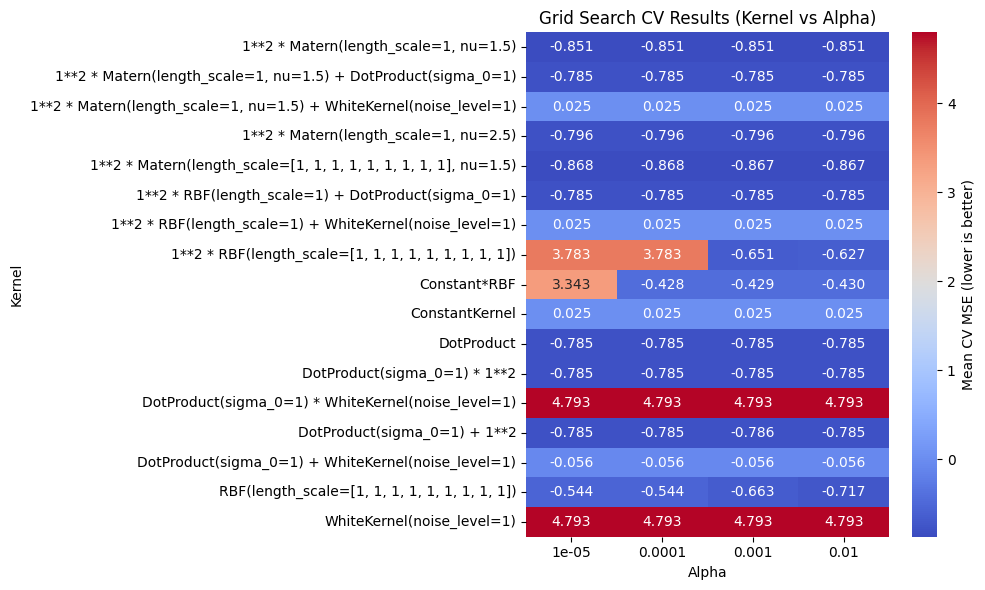

In [190]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Extract all results from GridSearchCV
cv_results = pd.DataFrame(rgr.cv_results_)

# To properly understand visually flip the sign of the mean test score (since it's negative MSE)
cv_results['mean_MSE'] = -cv_results['mean_test_score']

# Convert kernel objects to strings (so they're easy to plot)
cv_results['param_kernel'] = cv_results['param_kernel'].astype(str)
print(cv_results['param_kernel'].unique())

cv_results['param_kernel'] = cv_results['param_kernel'].replace({
    '1**2': 'ConstantKernel',
    '1**2 * RBF(length_scale=1)': 'Constant*RBF',
    'RBF(length_scale=1)': 'RBF',
    'DotProduct(sigma_0=1)': 'DotProduct',
    'WhiteKernel(noise_level=0.5)': 'WhiteKernel'
})


# Pivot the results: rows=kernels, columns=alpha, values=mean MSE
pivot_table = cv_results.pivot_table(
    values='mean_MSE',
    index='param_kernel',
    columns='param_alpha'
)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot_table,
    annot=True,
    fmt=".3f",
    cmap="coolwarm",
    cbar_kws={'label': 'Mean CV MSE (lower is better)'}
)
plt.title("Grid Search CV Results (Kernel vs Alpha)")
plt.xlabel("Alpha")
plt.ylabel("Kernel")
plt.tight_layout()
plt.show()


In [192]:

# Using the best values from GridSearchCV to train a final model and test on hold out test dataset
import numpy as np 

y_train_pred = rgr.predict(X_train_scaled)
print("\n=== Training Data Performance ===")
print(f"Train MSE: {mean_squared_error(y_train, y_train_pred):.4f}") # Mean Squared Error for training data
print(f"Train R²: {r2_score(y_train, y_train_pred):.4f}") # Metric for how well model performs on training data it already saw
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.2f}")

print("\n=== Test Data Performance ===")
y_test_pred = rgr.predict(X_test_scaled)
print(f"Test MSE: {mean_squared_error(y_test, y_test_pred):.4f}") # Mean Squared Error for test data
print(f"Test R²: {r2_score(y_test, y_test_pred):.4f}") # Metric for how well model performs on test data it hasn't seen before
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.2f}")


=== Training Data Performance ===
Train MSE: 0.0000
Train R²: 1.0000
Train RMSE: 0.00

=== Test Data Performance ===
Test MSE: 1226.4246
Test R²: 0.8524
Test RMSE: 35.02


/Users/georgea.e/Documents/Fourth Year/Machine Learning/Assignment 2/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(
